In [7]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [8]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), "-")
    
    def tanh(self):
        x = self.data
        out = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        return Value(out, (self, ), 'tanh')

In [9]:
### DRAW THE FUNCTION GRAPH

from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    nodes.add(root)
    def build(root):
        for child in root._prev:
            nodes.add(child)
            edges.add((child, root))
            build(child)
    
    build(root)
    return nodes, edges

def draw_graph(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR: Draw the graph from left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(uid, "{ %s | data = %.4f | grad = %.4f}" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            dot.node(uid+n._op, n._op)
            dot.edge(uid+n._op, uid)

    for e in edges:
        dot.edge(str(id(e[0])), str(id(e[1]))+e[1]._op)

    return dot

In [10]:
# Define backward() function for backtracking and calculating gradient

def reset_grad(n: Value):
    def trace_and_reset(n):
        if(n == None or n._prev == set()): # If n does not exist or if n does not have any parent
            return
        
        else:
            try:  # Try to get the 2 parents of n
                ch1, ch2 = n._prev

                ch1.grad = 0.0
                ch2.grad = 0.0

                trace_and_reset(ch1)
                trace_and_reset(ch2)
            except: # If there are not 2 parents, then there is only 1 parent
                ch1 = [i for i in n._prev][0]
                ch1.grad = 0.0
                trace_and_reset(ch1)
    trace_and_reset(n)

def backward(n: Value):
    reset_grad(n)
    n.grad = 1.0

    def trace_and_calculate_grad(n):
        if(n == None or n._prev == set()): # If n does not exist or if n does not have any parent
            return     
        else:
            try: # Try to get the 2 parents of n
                ch1, ch2 = n._prev
            except: # If there are not 2 parents, then there is only 1 parent
                ch1 = [i for i in n._prev][0]
        #print('n._op', n._op)
            
        if(n._op == '*'):
            ch1.grad += n.grad * (n.data/ch1.data)
            ch2.grad += n.grad * (n.data/ch2.data)

        elif(n._op == '+'):
            ch1.grad += n.grad
            ch2.grad += n.grad

        elif(n._op == 'tanh'):
            ch1.grad += n.grad # Using a a plceholder for now
            ch2 = None
            #print(f"ch1 = {ch1}")
            #trace_and_calculate_grad(ch1)

        trace_and_calculate_grad(ch1)
        trace_and_calculate_grad(ch2)

    trace_and_calculate_grad(n)
            

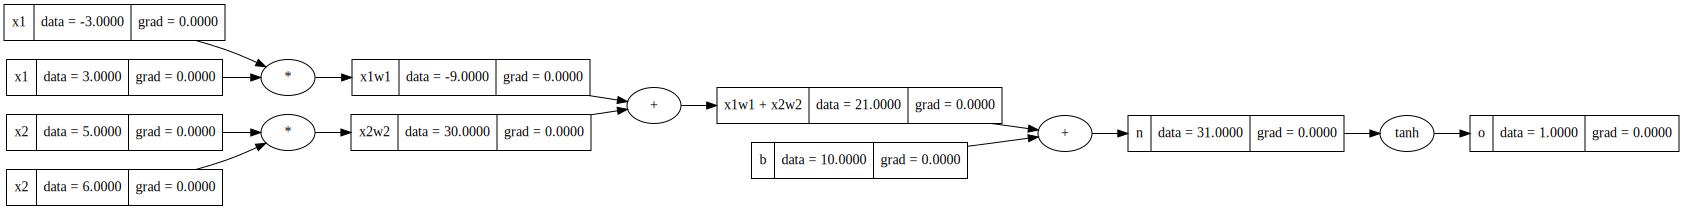

In [11]:
# Inputs
x1 = Value(3.0); x1.label = 'x1'
x2 = Value(5.0); x2.label = 'x2'

# Weights
w1 = Value(-3.0); w1.label = 'x1'
w2 = Value(6.0); w2.label = 'x2'

# Bias
b = Value(10.0); b.label = 'b'

# o = x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_graph(o)


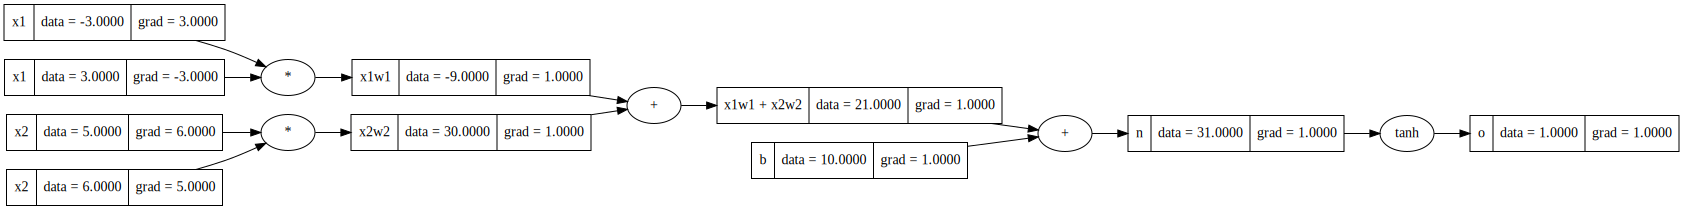

In [12]:
backward(o)
draw_graph(o)